In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install elephas
!pip install pyngrok==4.1.1
# !pip install pyspark
!apt install openjdk-8-jdk-headless --yes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 57.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=2

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15964 sha256=1c94d71822e9318dd616ea899aae4af421f8a3fb8df2c464a2e0ca14be99fdc7
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.co

In [ ]:
#imports
import io
import os
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
from pyngrok import ngrok
from zipfile import ZipFile
#pyspark
import pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType,StructField,ArrayType,StringType,LongType,BinaryType,IntegerType,FloatType,DoubleType
from pyspark import SparkContext, SparkConf
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator, ElephasTransformer,load_ml_transformer
from elephas.utils.model_utils import ModelType
#Keras Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from keras .models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers

plt.rcParams["figure.figsize"] = (8,5.5)

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.driver.memory', '100G').set('spark.driver.maxResultSize', '100G')
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "32")

In [ ]:
!killall ngrok
!ngrok authtoken {'296gloYMZx0IEn84mbVMCKzo1SV_6Sp5sYcPoFygBrSxhqrgs'}
public_url = ngrok.connect(port='4050')
print("Pyspark UI URL : ",public_url)
## use to kill ngrock sessions
# !killall ngrok

ngrok: no process found
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Pyspark UI URL :  http://dbb0-34-80-163-5.ngrok-free.app


In [ ]:

with ZipFile('/content/drive/MyDrive/archive (8).zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('unzip_tumor')
   print('File is unzipped in temp folder')

File is unzipped in temp folder


# **Data Preprocessing**
Remove some data to escape memory issues: After removing data.
Get labels names from the folder names and encode them in dictionary.
Import all data after resizing the into pyspark dataframe and label it.
resize size of images and flatten them into a list.
Convert the array into Dense Vector type for pyspark compatibility.

In [ ]:
rootdir = '/content/unzip_tumor/Training'
for it in os.scandir(rootdir):
  if it.is_dir():
    count = 0
    dir_path = it.path
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
            if count>1800:
              os.remove(path)
    print(it.path)

/content/unzip_tumor/Training/glioma_tumor
/content/unzip_tumor/Training/no_tumor


In [ ]:
for it in os.scandir(rootdir):
  if it.is_dir():
    count = 0
    dir_path = it.path
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
    print(it.path)
    print('file count:', count)

/content/unzip_tumor/Training/glioma_tumor
file count: 826
/content/unzip_tumor/Training/no_tumor
file count: 395


In [ ]:
# Viewing data elements
print('Folder Dataset Information : \n' + '='*2)
for labelpath, labelnames, filenames in os.walk('.'):
  print(f"There is {len(labelnames)} folder and have {len(filenames)} files inside {labelpath}")

Folder Dataset Information : 
==
There is 4 folder and have 0 files inside .
There is 2 folder and have 7 files inside ./.config
There is 0 folder and have 1 files inside ./.config/configurations
There is 1 folder and have 0 files inside ./.config/logs
There is 0 folder and have 6 files inside ./.config/logs/2023.08.23
There is 5 folder and have 0 files inside ./drive
There is 0 folder and have 0 files inside ./drive/Shareddrives
There is 0 folder and have 0 files inside ./drive/.file-revisions-by-id
There is 0 folder and have 0 files inside ./drive/.shortcut-targets-by-id
There is 8 folder and have 17 files inside ./drive/MyDrive
There is 1 folder and have 0 files inside ./drive/MyDrive/Classroom
There is 0 folder and have 0 files inside ./drive/MyDrive/Classroom/PDS_Fall(22-23) L11+L12+L29+L30+L49+L50
There is 0 folder and have 35 files inside ./drive/MyDrive/Colab Notebooks
There is 0 folder and have 6 files inside ./drive/MyDrive/python
There is 0 folder and have 2 files inside ./d

In [ ]:
# data train in each labels
print('Tumor Labels in Train Set : \n' + '='*50)
for labelpath, labelname, file in os.walk('/content/unzip_tumor/Training'):
  if labelpath.split("/")[-1] != 'train':
    print(f'There are {len(file)} images classification as {labelpath.split("/")[-1]}')

Tumor Labels in Train Set : 
There are 0 images classification as Training
There are 826 images classification as glioma_tumor
There are 395 images classification as no_tumor


In [ ]:
# see label class on training dataset
labels = pathlib.Path('/content/unzip_tumor/Training')
label_names=np.array(sorted([item.name for item in labels.glob('*')]))
print(label_names)

['glioma_tumor' 'no_tumor']


Found 1221 files belonging to 2 classes.


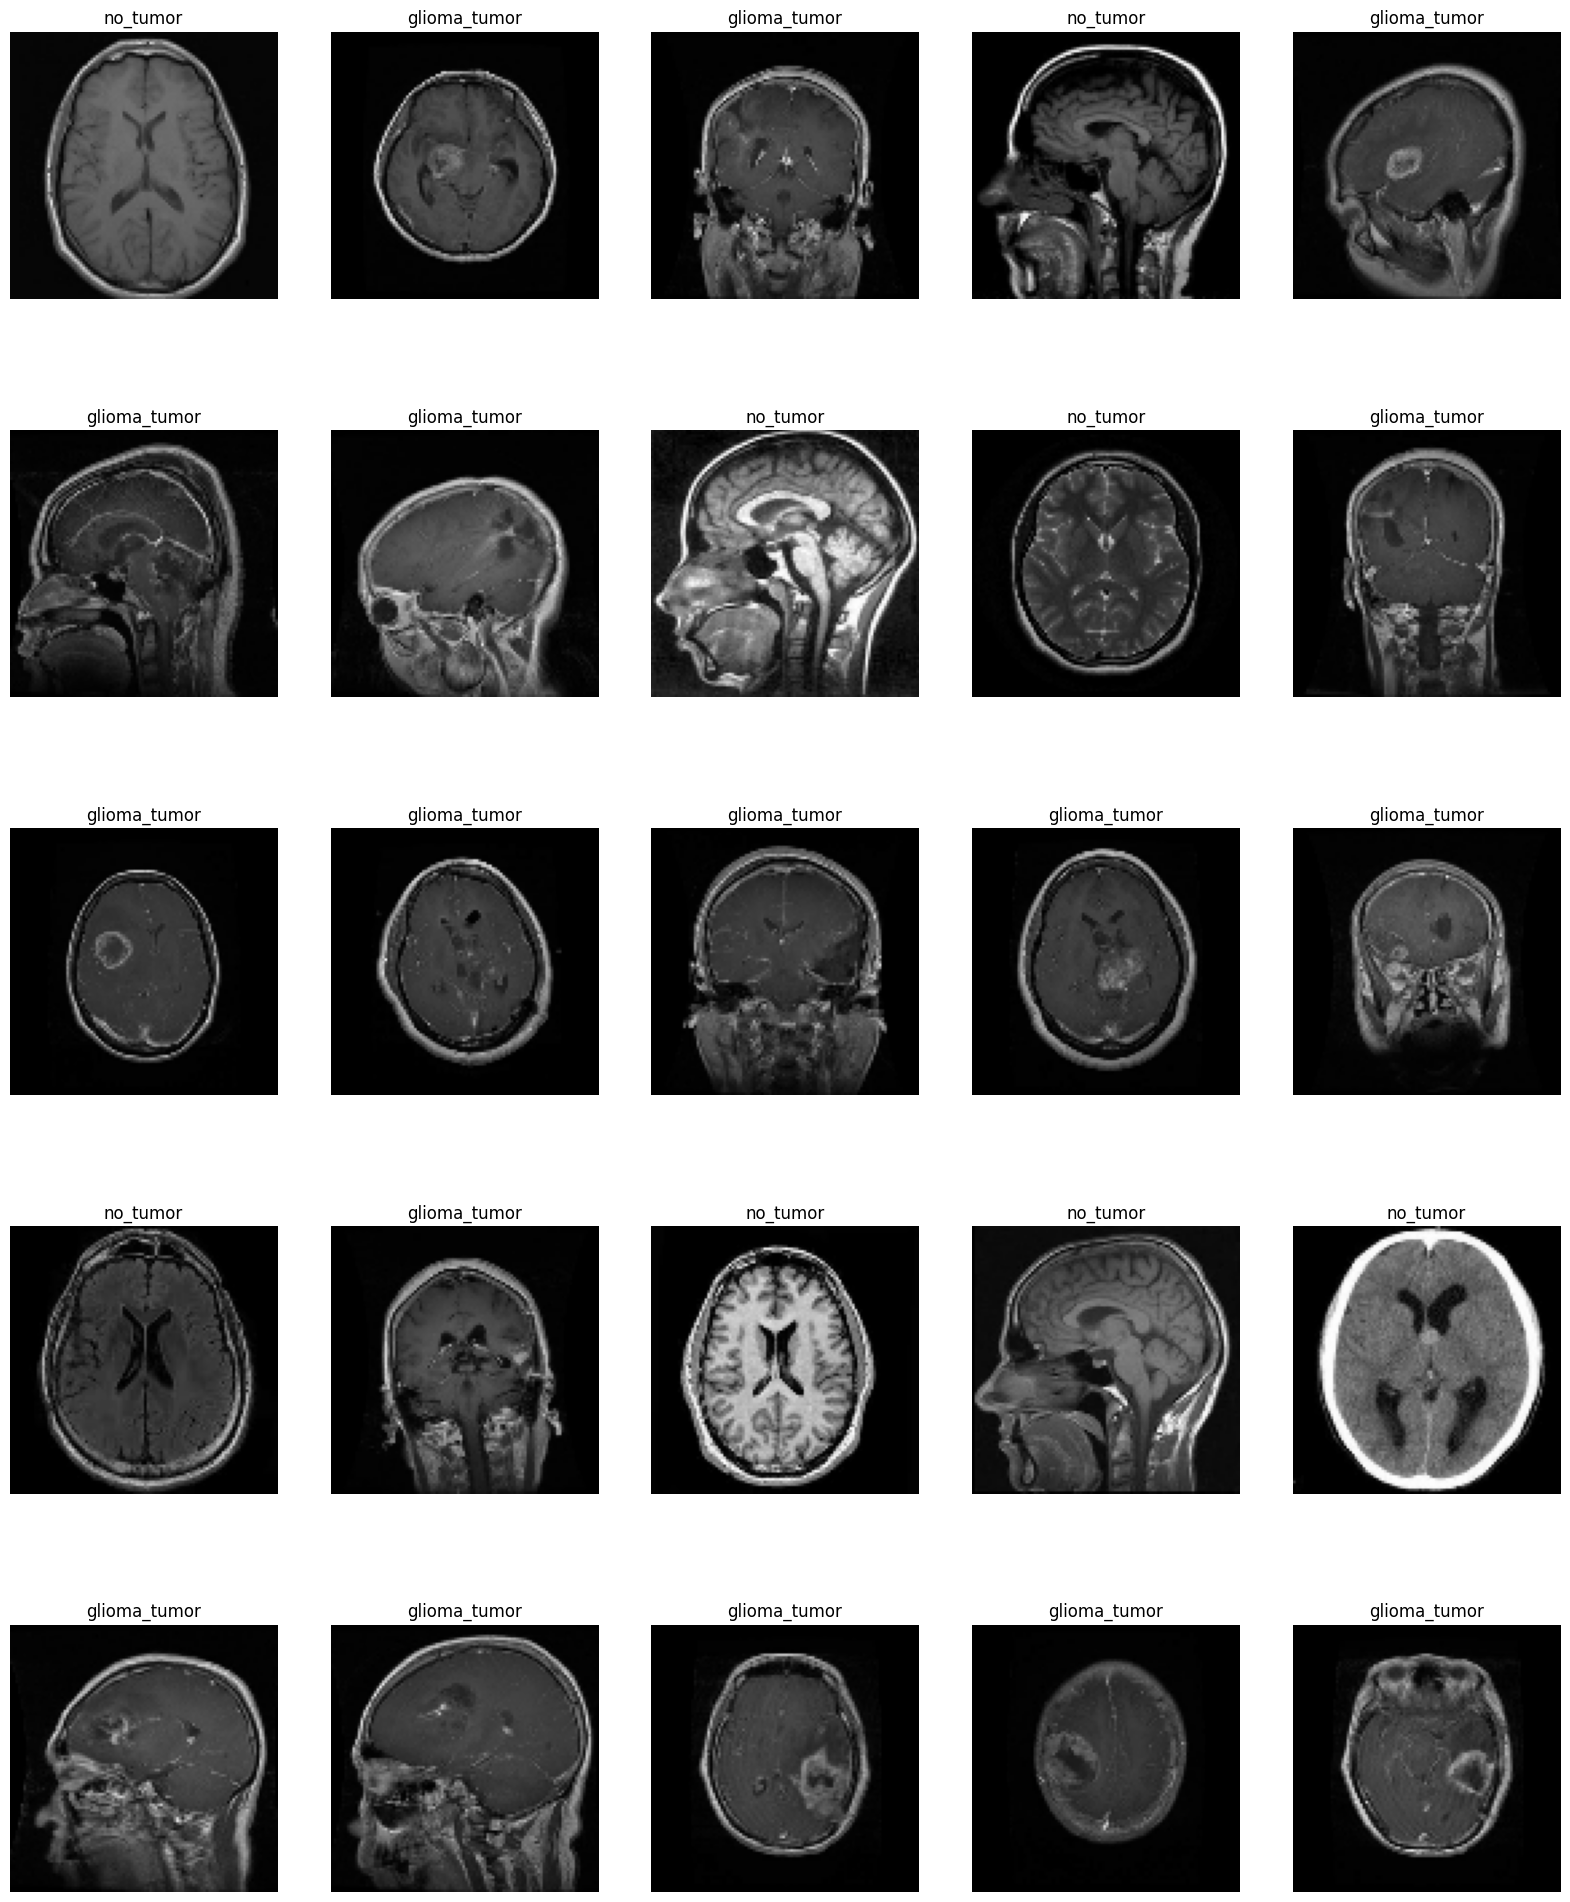

In [ ]:
# visualize sample images
train_dir='/content/unzip_tumor/Training'
attribute = image_dataset_from_directory(train_dir, image_size=(100,100))
plt.figure(figsize=(20,25))
for image, labels in attribute.take(1):
  for i in range (25):
    plt.subplot(5,5, i + 1)
    plt.imshow(np.array(image[i]).astype("uint8"))
    plt.title(attribute.class_names[labels[i]])
    plt.axis("off")

In [ ]:
selected_tumor=['no_tumor','glioma_tumor']
rootdir = '/content/unzip_tumor/Training'
rootdir_test='/content/unzip_tumor/Testing'
get_label={}
i=0
for it in os.scandir(rootdir):
    class_plant=os.path.basename(os.path.normpath(it.path))
    if it.is_dir() and class_plant.startswith(tuple(selected_tumor)):
      get_label[class_plant]=i
      i=i+1

In [ ]:
get_label

{'glioma_tumor': 0, 'no_tumor': 1}

In [ ]:
image_h=24
image_w=24
channels=3
#create empty datframe
emptyRDD = spark.sparkContext.emptyRDD()
schema =StructType([
        StructField('content',BinaryType(),True),
        StructField('label',IntegerType(),True)
    ])
images_df = spark.createDataFrame(emptyRDD,schema)

#import data
for it in os.scandir(rootdir):
    class_tumor=os.path.basename(os.path.normpath(it.path))
    if it.is_dir() and class_tumor.startswith(tuple(selected_tumor)):
        print("Adding Class into Data Frame ------->",class_tumor)
        single_df=spark.read.format("BinaryFile").load(it.path).withColumn("label", lit(get_label[class_tumor]))
        single_df=single_df.select('content','label')
        images_df=images_df.union(single_df)
        single_df.unpersist(blocking=True)

def featurizer(content):
    imm=img_to_array((Image.open(io.BytesIO(content)).resize([image_h,image_w])),dtype='float16')/255
    return imm.flatten().tolist()

convertUDF = udf(lambda z: featurizer(z), ArrayType(FloatType()))
images_df=images_df.repartition(64).select(convertUDF("content").alias("features"),col("label"))

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
images_df = images_df.select(
col("label"),list_to_vector_udf(images_df["features"]).alias("features"))
# train, test = images_df.randomSplit(weights=[0.7,0.3], seed=123)

Adding Class into Data Frame -------> glioma_tumor
Adding Class into Data Frame -------> no_tumor


**Modelling of Data**:

Create a neural netwrok model that :

Reshape the data from flat list to original shape
Has Convolutional neural network model for feature extraction.
Fully connected layers for cllassification
Elephas is used to enable distributed computing. It is an extension of Keras, which allows you to run distributed deep learning models at scale with Spark.

In [ ]:
#less computational way
input_dim = image_w*image_h*channels

In [ ]:
nb_classes=len(get_label)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Reshape
model=Sequential()
model.add(Reshape((image_w,image_h,3), input_shape=(input_dim,)))
model.add(Conv2D(64, (2, 2), activation='relu', input_shape=(image_w,image_h,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Flatten())
model.add (Dropout (rate=0.5))
model.add (Dense (256))
model.add (Activation('relu'))
model.add (Dropout(rate=0.25))
model.add (Dense (nb_classes))
model.add (Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',run_eagerly=True)

In [ ]:
# Set and Serialize Optimi zer
optimizer_conf = tf.keras.optimizers.Adam(0.0001)
opt_conf = optimizers.serialize(optimizer_conf)
#Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("label")
estimator.set_keras_model_config(model.to_json())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(10)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.20)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss ("categorical_crossentropy")
estimator.set_metrics (['acc'])
import time

# Start the timer
start_time = time.time()

# Code block to measure the execution time
# Replace this with your actual code
for i in range(1000000):
    pass

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed Time:", elapsed_time, "seconds")

Elapsed Time: 0.07630729675292969 seconds


In [ ]:
tran=estimator.fit(images_df)
#Save elephas tranformer for using on testing data and streamlit application.
tran.save("colab_elephas_transformer_2june_v4.h5")
import time

# Start the timer
start_time = time.time()

# Code block to measure the execution time
# Replace this with your actual code
for i in range(1000000):
    pass

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed Time:", elapsed_time, "seconds")

>>> Fit model
>>> Synchronous training complete.
Elapsed Time: 0.07789373397827148 seconds


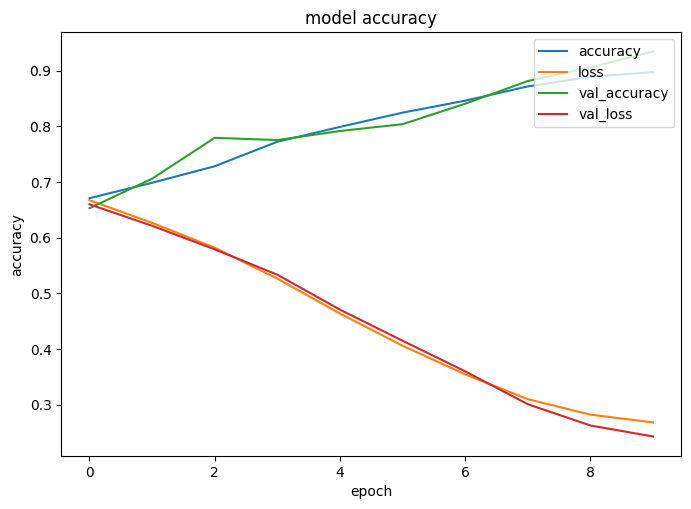

In [ ]:
train_acc=tran.history[0]['acc']
train_loss=tran.history[0]['loss']
val_acc=tran.history[0]['val_acc']
val_loss=tran.history[0]['val_loss']

plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='upper right')
plt.savefig('acc_2_june_v4.png')
plt.show()